In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# index = sys.path.index('')
# sys.path.pop(index)
path = sys.path[0]
parent_dir = os.path.abspath(os.path.join(path, os.pardir))

for root, dirs, files in os.walk(parent_dir):
    for dir in dirs:
        sys.path.append(os.path.join(root, dir))

sys.path.append(parent_dir)
sys.path.pop(0)
print(sys.path)

['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/home/khoi-nguyen/qutrit_qoc/.venv/lib/python3.11/site-packages', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/output', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/quantum_optimal_control', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/experiments', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/refs', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/info', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/hooks', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/branches', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/objects', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/logs', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/refs/tags', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/refs/remotes', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/refs/heads', '/home/khoi-nguyen/qutrit_qoc/GRAPE-for-qubit/.git/refs

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import inspect

from quantum_optimal_control.helper_functions.grape_functions import *
from quantum_optimal_control.main_grape.grape import Grape

data_path = '../output/x01_π/'

2023-10-07 21:41:16.191866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 21:41:16.453832: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 21:41:16.453906: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 21:41:16.455796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 21:41:16.606059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 21:41:16.607107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [21]:
from qiskit_ibm_provider import IBMProvider

IBMProvider.save_account('030e0f3b6562aeef01f326920c2b5c95160de76135f801f67cce23704c77a274aa5241b45c7777d8a2bcfb4c71803c8796f4d6896241914aba81fc7281bae508', overwrite=True)

provider = IBMProvider()
backend = provider.get_backend('ibm_lagos')

In [22]:
ns = 1.0e9
config = backend.configuration()
dt = config.dt
acquire_alignment = config.timing_constraints['acquire_alignment']
granularity = config.timing_constraints['granularity']
pulse_alignment = config.timing_constraints['pulse_alignment']
lcm = np.lcm(acquire_alignment, pulse_alignment)

In [23]:
qubit = 0
f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9

In [24]:
f01

5235359100.418953

In [25]:
anhar

-339867138.55915606

In [5]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [39]:
def ket(i):
  if(i == 0):
    return np.array([[1], [0], [0], [0]])
  if(i == 1):
    return np.array([[0], [1], [0], [0]])
  if(i == 2):
    return np.array([[0], [0], [1], [0]])
  if(i == 3):
    return np.array([[0], [0], [0], [1]])

def bra(i):
  if(i == 0):
    return np.array([[1, 0, 0, 0]])
  if(i == 1):
    return np.array([[0, 1, 0, 0]])
  if(i == 2):
    return np.array([[0, 0, 1, 0]])
  if(i == 3):
    return np.array([[0, 0, 0, 1]])

def Pi(i):
  return ket(i)*bra(i)

def sigma_x(i, j):
  return ket(j)@bra(i) + ket(i)@bra(j)

def sigma_y(i, j):
  return 1j*(ket(j)@bra(i) - ket(i)@bra(j))

def sigma_z(i, j):
  return ket(i)@bra(i) - ket(j)@bra(j)

In [3]:
ns = 1.0e9
dt = 2/9/ns
f01 = 5235359100.418953
anhar = -339867138.55915606

In [30]:
#Defining time scales

steps = 144 #1-2: 160
# steps = get_closest_multiple_of_16(steps)
total_time = steps * dt * ns #ns dt = 0.2222222222

# Choose optimizing State transfer or Unitary gate
state_transfer = True

#Defining H0
qubit_state_num = 4 #change
qubit_num = 1 
freq_ge = f01/ns #GHz #change
alpha = anhar/ns
g_ops = 0.073036776 #GHz #change

ens = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(np.arange(0,qubit_state_num))
Q_I   = np.identity(qubit_state_num)
H_q = np.diag(ens)

H0 = H_q

#Defining Concerned states (starting states)
psi0 = ket(0)

#Defining states to include in the drawing of occupation
states_draw_list = [0,1]
states_draw_names = ['0','1']

#Defining U (Target)
U = []

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num**qubit_num)
U0 = q_identity

#Defining control Hs
XI = Q_x
YI = Q_y
ZI = Q_z
Hops = [XI, YI]
g_ops = 0.073036776 
ops_max_amp = [2 * np.pi * g_ops, 2 * np.pi * g_ops] # = Omega_{d, 0}
Hnames = ['x', 'y']

print(Hnames)

#Defining convergence parameters
max_iterations = 1000
decay = 5000 #max_iterations/2
convergence = {'rate': 0.1, 'update_step': 1, 'max_iterations': max_iterations, 'conv_target': 1e-6, 'learning_rate_decay': decay}

# guassian envelope pulse
reg_coeffs = {'envelope': 0.1, 'dwdt': 0.001}

['x', 'y']


In [32]:
H0

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  32.89473138,   0.        ,   0.        ],
       [  0.        ,   0.        ,  67.92491097,   0.        ],
       [  0.        ,   0.        ,   0.        , 105.09053877]])

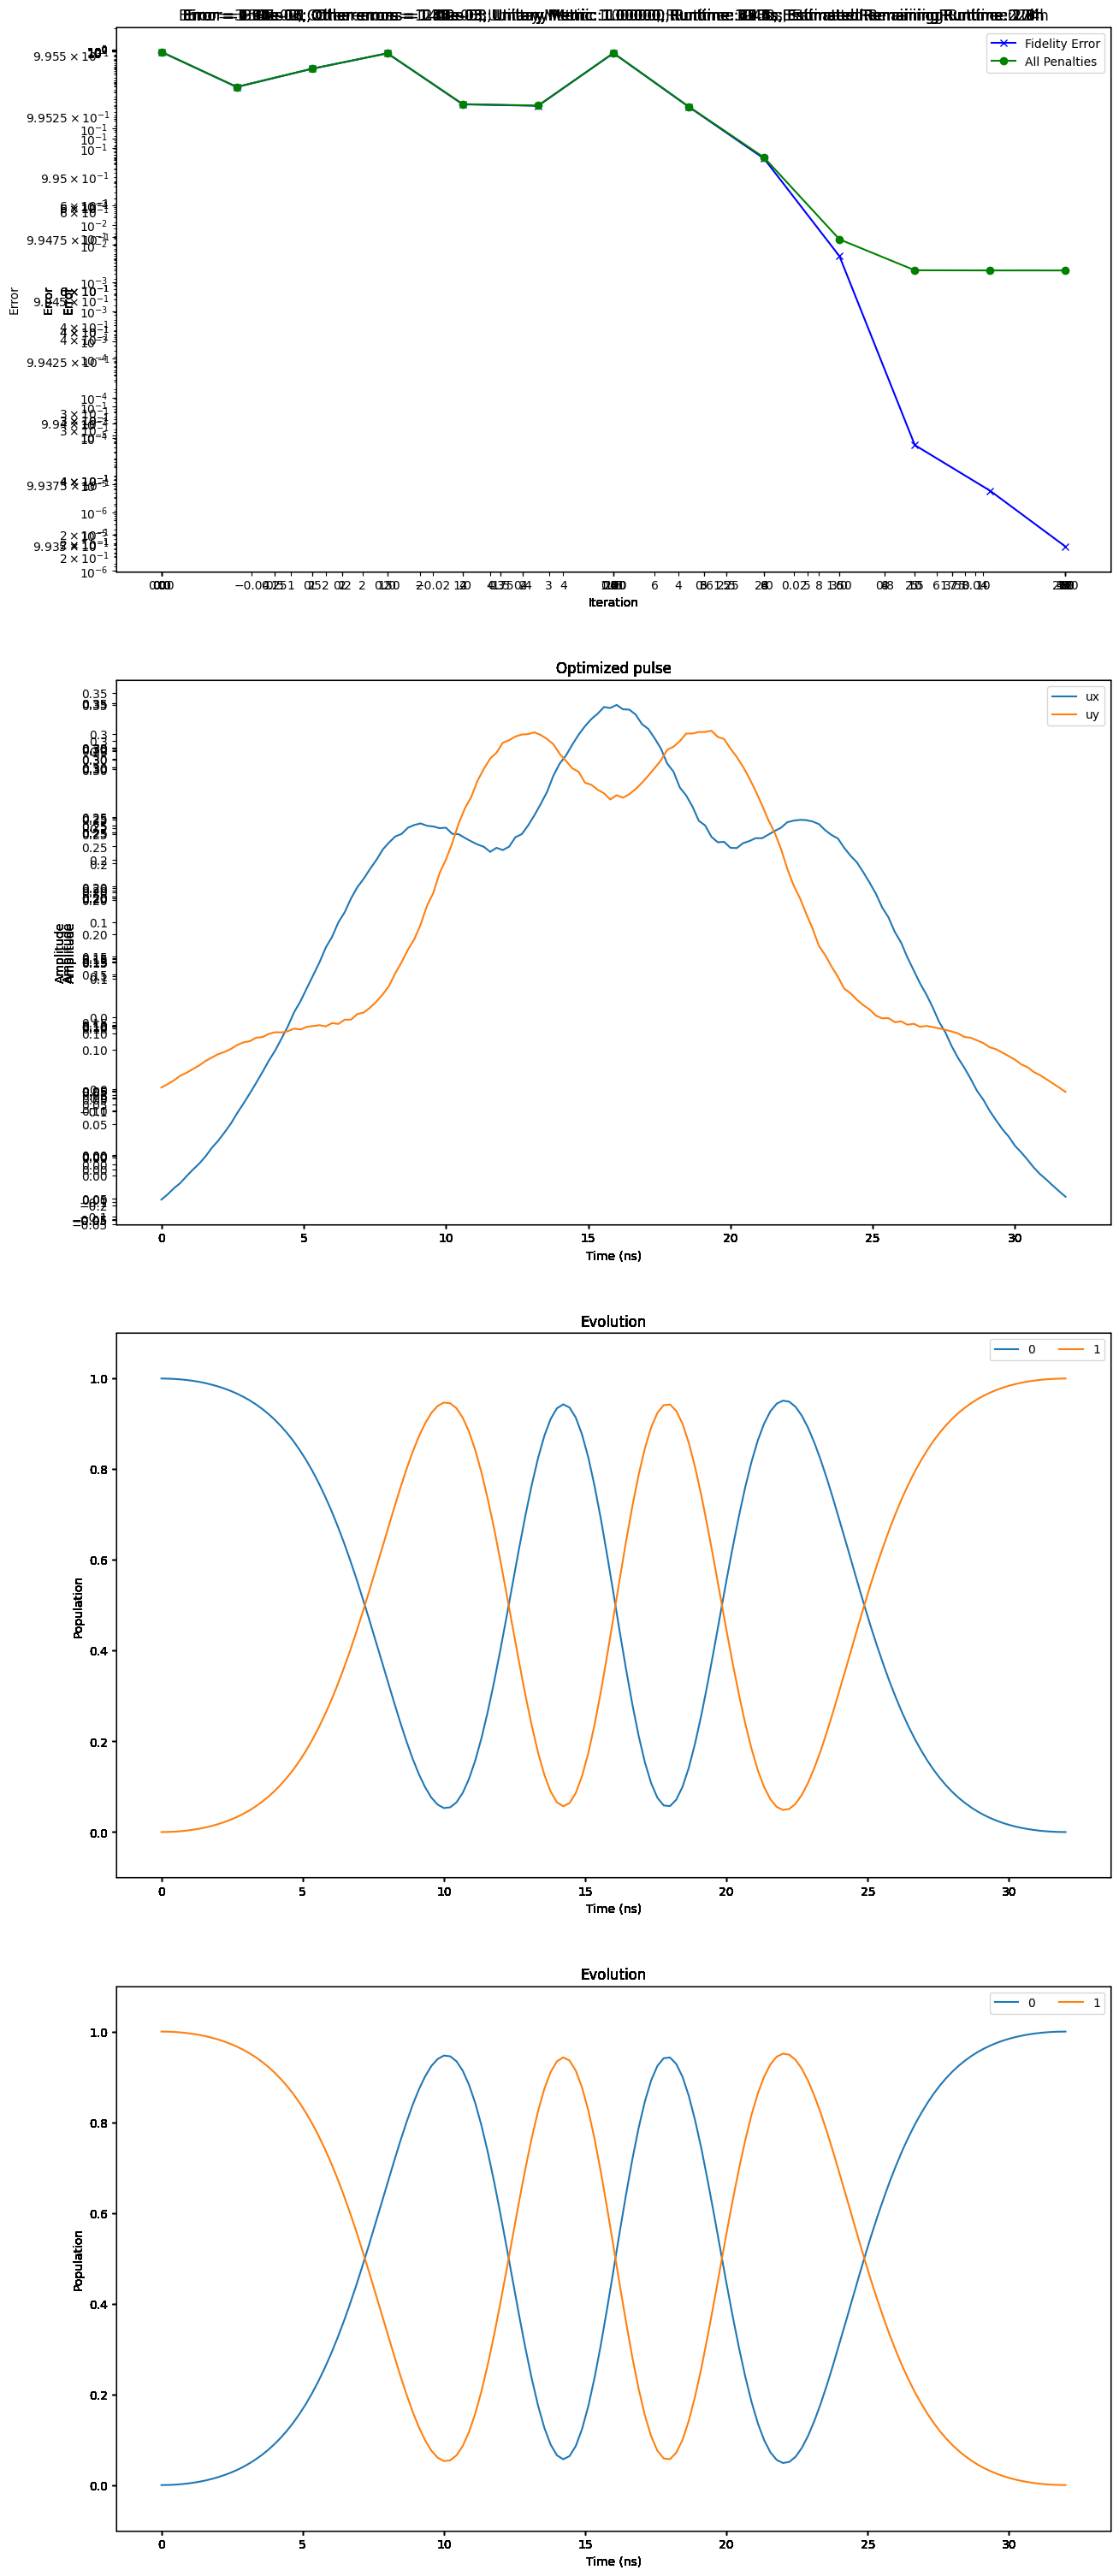

In [5]:
uks, U_final = Grape(H0, Hops, Hnames, U, total_time, steps, psi0,
                    convergence = convergence, 
                    draw = [states_draw_list, states_draw_names],
                    state_transfer = True,
                    use_gpu = False,
                    sparse_H = False,
                    show_plots = True, 
                    unitary_error = 1e-6, 
                    method = 'L-BFGS-B', 
                    maxA = ops_max_amp,
                    Taylor_terms = [20,0],
                    reg_coeffs = reg_coeffs,
                    save = True,
                    file_name = 'x01_lagos',
                    data_path = data_path)